# Imports

In [1]:
import numpy as np
from scipy.optimize import minimize, linprog
import random
import multiprocessing
import itertools
import pandas as pd
import cvxpy as cp
import ast
import timeit
import matplotlib.pyplot as plt
import knapsack

In [2]:
np.random.seed(1)

In [77]:
c = 25 # cache capacity
k = 5 # each user should be in at most K reachable sets
m = 2 # at most M items can be initially recommended to each user
L = 5 # the total number of items that the user will receive either through 
# direct recommendation or indirectly (because it is in reachable sets of users to whom items 
#have been recommended) should not be more than L

# Create random Reachable sets

In [ ]:
number_of_items = 10
number_of_users = 12
items= np.array(range(0,number_of_items)) # videos
users = np.array(range(0,number_of_users)) # users
np.random.shuffle(items)
np.random.shuffle(users)
# initialize x0 for the optimization
x = np.full(len(items),0.05)
y = np.full((len(items), len(users)),0.05)
x0 = np.concatenate([x.flatten(), y.flatten()])
# Random Reachable sets
reachable_sets = np.array(np.array([[np.array(random.sample(list(users), random.choice(users))) for user in users] for i in items]))
# reachable_sets_dict = {}
# for i in items:
#     dic = {}
#     for user in users:
#         dic[user] = np.array(random.sample(list(users), random.choice(users)))
#     reachable_sets_dict[i] = dic
        

I = np.zeros((len(items), len(users), len(users)))
for i in items:
    for u in users:
        for v in reachable_sets[i][u]:
            I[i][u][v] = 1

# Read real data

In [3]:
data = pd.read_csv('r_i_u_10_200.txt',sep='-', names=['ItemID','UserID','ReachableSet','ReachableSet2'])

In [4]:
data['Item'] = data.ItemID.astype("category").cat.codes
data['User'] = data.UserID.astype("category").cat.codes

In [5]:
mappingItemID = {}
mappingUserID = {}
def l(row):
    mappingItemID[row['ItemID']] = row['Item']
    mappingUserID[row['UserID']] = row['User']
data.apply(lambda row:l(row),axis=1)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
1970    None
1971    None
1972    None
1973    None
1974    None
1975    None
1976    None
1977    None
1978    None
1979    None
1980    None
1981    None
1982    None
1983    None
1984    None
1985    None
1986    None
1987    None
1988    None
1989    None
1990    None
1991    None
1992    None
1993    None
1994    None
1995    None
1996    None
1997    None
1998    None
1999    None
Length: 2000, dtype: object

In [6]:
def l2(row):
    
    row_list = ast.literal_eval(row['ReachableSet'])
#     new_list = list()
#     for i in row_list:
#         try:
#             new_list.append(mappingUserID[i])
#         except:
#             mappingUserID[i]
    
    return [mappingUserID[i] for i in row_list]
    
data['ReachableSet2'] = data.apply(lambda row:l2(row),axis=1)

In [7]:
reachable_sets_df = data[['Item','User','ReachableSet2']]
reachable_sets_df.rename(columns={'ReachableSet2': 'ReachableSet'}, inplace=True)

/home/spiros/env/lib/python3.5/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [8]:
reachable_sets_df.loc[(reachable_sets_df['Item'] == 0) & (reachable_sets_df['User'] == 0)]['ReachableSet'].max()

[]

In [9]:
# ast.literal_eval(reachable_sets_df.loc[(reachable_sets_df['Item'] == 0) & (reachable_sets_df['User'] == 0)]['ReachableSet'].max())

In [10]:
number_of_items = len(reachable_sets_df['Item'].unique())
number_of_users = len(reachable_sets_df['User'].unique())
items= np.array(range(0,number_of_items)) # videos
users = np.array(range(0,number_of_users)) # users
np.random.shuffle(items)
np.random.shuffle(users)
# initialize x0 for the optimization
# x = np.full(len(items),0.5)
# y = np.full((len(items), len(users)),0.5)
x = np.random.uniform(low=0.0, high=1.0, size=len(items))
y = np.random.uniform(low=0.0, high=1.0, size=(len(items), len(users)))
x0 = np.concatenate([x.flatten(), y.flatten()])

# Real Reachable sets
reachable_sets = np.array(np.array([[np.array(reachable_sets_df.loc[(reachable_sets_df['Item'] == i) & (reachable_sets_df['User'] == user)]['ReachableSet'].max()) for user in users] for i in items]))

        
I = np.zeros((len(items), len(users), len(users)))
for i in items:
    for u in users:
        for v in reachable_sets[i][u]:
            I[i][u][v] = 1

In [11]:
reachable_sets[0][0]

array([], dtype=float64)

# Save the size of each intersection of reachable sets to a numpy array

In [12]:
intersections = np.zeros((len(items),len(users),len(users)))
for i in items:
    for u in users:
        for v in users:
            if v!=u:
                intersections[i][u][v] = len(set(reachable_sets[i][u])&set(reachable_sets[i][v]))

# Save the size of each reachable set to a numpy array

In [13]:
size_of_sets = np.vectorize(len)
reachable_sets_len = size_of_sets(reachable_sets)

In [14]:
reachable_sets_len.mean()

0.085

In [15]:
reachable_sets.shape

(200, 10)

# Save the size of each intersection of reachable sets to a dictionary

In [ ]:
# intersections = np.zeros((len(items),len(users),len(users)))
# intersections = {}
# for item,row in reachable_sets_dict.items():
#     dic1={}
#     for user1,x in row.items():
#         dic2={}
#         for user2,y in row.items():
#             dic2[user2] = len(set(x)&set(y))
#         dic1[user1]=dic2
#     intersections[item]=dic1
            
        

In [ ]:
np.einsum('ijk,ik->ij',intersections,y).shape

In [ ]:
np.dot(y,np.einsum('ijk,ik->ij',intersections,y).T).shape

# Objective function

In [101]:
def objective(z):
#     x = z[:len(items)][np.newaxis]
#     y = z[len(items):].reshape(len(items),len(users))[np.newaxis]
    
    x = z[:len(items)]
    y = z[len(items):].reshape(len(items),len(users))
    
    
    #The first term in (1) counts the users to which an item is 
    #initially recommended and the users in the ensuing reachable sets
    #first_term = sum([(1+len(reachable_sets[i][u])) * y[i][u] for u in users])
    #The second term in (1) is due to the overlap of reachable sets Riu,Riv
    #second_term = 0.5*sum([sum([len(set(reachable_sets[i][u])&set(reachable_sets[i][v]))*y[i][u]*y[i][v] for v in users if v!=u]) for u in users])
    # Ekfonisi
    #return -sum([x[i]*(sum([(1+len(reachable_sets[i][u])) * y[i][u] for u in users]) - 0.5*sum([sum([len(set(reachable_sets[i][u])&set(reachable_sets[i][v]))*y[i][u]*y[i][v] for v in users if v!=u]) for u in users])) for i in items])
    # Paper
    #return x.sum()
    #return -(np.dot(x,((((1+reachable_sets_len)*y)-0.5*()).sum(axis=0)))).sum(axis=1)
    #return -sum([x[i]*sum([(1+len(reachable_sets[i][u])) * y[i][u] - 0.5*sum([len(set(reachable_sets[i][u])&set(reachable_sets[i][v]))*y[i][u]*y[i][v] for v in users if v!=u]) for u in users]) for i in items])
    #return -sum([x[i]*sum([(1+reachable_sets_len[i][u]) * y[i][u] - 0.5*sum([intersections[i][u][v]*y[i][u]*y[i][v] for v in users if v!=u]) for u in users]) for i in items])
    
    
    #return -(np.dot(x,(np.dot((1+reachable_sets_len),y.T)-0.5*(np.dot(y,np.einsum('ijk,ik->ij',intersections,y).T)))))
    #return -np.dot(x,(((1+reachable_sets_len)*y).sum(axis=1) - 
    #                  0.5*(y*((y[:,:,None]*intersections).sum(axis=2))).sum(axis=1)))
    return -sum([x[i]*(np.dot(y[i].T,(1+reachable_sets_len[i])) - 0.5*np.dot(np.dot(y[i].T,(intersections[i])).T, y[i]))for i in items])

# Constraint (2) is the cache capacity constraint

In [ ]:
def constraint2(z):  
    x = z[:len(items)]
    
    return sum([x[i] for i in items]) - c

# Constraint (3) says that at most M items can be initially recommended to each user

In [ ]:
def constraint3(z):  
    y = z[len(items):].reshape(len(items),len(users))
    
    return [(-sum([y[i][u] for i in items]))+m for u in users]

# Constraint (4) says that each user should be in at most K reachable sets these capture content consumption, attention span or time constraints

In [ ]:
def constraint4(z):  
    y = z[len(items):].reshape(len(items),len(users))
    
    return [-sum([sum([I[i][u][v]*y[i][u] for u in users]) for i in items])+k for u in users]

# Constraint (6) says that the total number of items that the user will receive either through direct recommendation or indirectly (because it is in reachable sets of users to whom items have been recommended) should not be more than L

In [ ]:
def constraint6(z):
    y = z[len(items):].reshape(len(items),len(users))
    

    return [-sum([y[i][u] for i in items]) - sum([sum([I[i][u][v]*y[i][u] for v in users]) for i in items])+L for u in users]

# Solve

In [ ]:

start_time = timeit.default_timer()
con2 = {'type': 'eq', 'fun': constraint2} 
con3 = {'type': 'ineq', 'fun': constraint3} 
con4 = {'type': 'ineq', 'fun': constraint4} 
con6 = {'type': 'ineq', 'fun': constraint6}
cons = ([con2, con6])
# Bounds
b = (0.0,1.0)
bnds = [b for i in range(len(x0))]

# show initial objective
print('Initial Objective: ' + str(-1*objective(x0)))

solution = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True, 'maxiter':100})
elapsed = timeit.default_timer() - start_time
print("Elapsed time: "+str(elapsed)+" sec")

In [ ]:
x = solution.x

# show final objective
print('Final Objective: ' + str(-1*objective(x)))

In [ ]:
solution

In [ ]:
solution.x.shape

In [ ]:
x = solution.x[:len(items)].round()
y = solution.x[len(items):].reshape(len(items),len(users)).round()

# Solution

## Items in cache

In [ ]:
x

In [ ]:
x.sum()

In [ ]:
x.shape

## Recommended items

In [ ]:
y

In [ ]:
y.sum(axis=0) # items recommended to each user

In [ ]:
y.shape

In [ ]:
y[np.nonzero(y)].sum()/np.prod(y.shape)

In [ ]:
print("C="+str(c))
print("L="+str(L))
print("Users="+str(y.shape[1]))
print("Items="+str(y.shape[0]))
print('Final Objective: ' + str(-1*objective(solution.x)))

In [ ]:
results_df = pd.DataFrame({'C':c,
                          'L':L,
                          'Users':y.shape[1],
                          'Items':y.shape[0],
                          'Objective':str(-1*objective(solution.x))}, index=[0])

In [ ]:
with open('results.csv', 'a') as f:
        results_df.to_csv(f, header=False)    

# Auto generate plots

In [104]:
c=5
for L in [5, 10, 20, 30, 50]:
    def constraint2(z):  
        x = z[:len(items)]
    
        return sum([x[i] for i in items]) - c

    def constraint6(z):
        y = z[len(items):].reshape(len(items),len(users))
    

        return [-sum([y[i][u] for i in items]) - sum([sum([I[i][u][v]*y[i][u] for v in users]) for i in items])+L for u in users]

    
    start_time = timeit.default_timer()
    con2 = {'type': 'eq', 'fun': constraint2} 

    con6 = {'type': 'ineq', 'fun': constraint6}
    cons = ([con2, con6])
    # Bounds
    b = (0.0,1.0)
    bnds = [b for i in range(len(x0))]

    # show initial objective
    print('Initial Objective: ' + str(-1*objective(x0)))

    solution = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True, 'maxiter':100})
    elapsed = timeit.default_timer() - start_time
    print("Elapsed time: "+str(elapsed)+" sec")
    
    x = solution.x

    # show final objective
    print('Final Objective: ' + str(-1*objective(x)))
    
    print("C="+str(c))
    print("L="+str(L))
    print("Users="+str(y.shape[1]))
    print("Items="+str(y.shape[0]))
    print('Final Objective: ' + str(-1*objective(solution.x)))
    
    results_df = pd.DataFrame({'C':c,
                          'L':L,
                          'Users':y.shape[1],
                          'Items':y.shape[0],
                          'Objective':str(-1*objective(solution.x))}, index=[0])
    
    with open('results.csv', 'a') as f:
        results_df.to_csv(f, header=False)    

Initial Objective: 463.461539572837
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -50.00000005197799
            Iterations: 6
            Function evaluations: 13212
            Gradient evaluations: 6
Elapsed time: 1245.0348036710056 sec
Final Objective: 50.00000005197799
C=5
L=5
Users=10
Items=200
Final Objective: 50.00000005197799
Initial Objective: 463.461539572837
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -61.0
            Iterations: 5
            Function evaluations: 11010
            Gradient evaluations: 5
Elapsed time: 1011.6325153329963 sec
Final Objective: 61.0
C=5
L=10
Users=10
Items=200
Final Objective: 61.0
Initial Objective: 463.461539572837
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -61.000000009906806
            Iterations: 6
            Function evaluations: 13212
            Gradient evaluations: 6
Elapsed time: 1225.004641

In [ ]:
# results_df.to_csv('results.csv')

In [ ]:
# x = cp.Variable(x.shape, integer=False)
# y = cp.Variable(y.shape, integer=False)
# prob = cp.Problem(#cp.Maximize(np.dot(x,(((1+reachable_sets_len)*y).sum(axis=1) - 0.5*(y*((y[:,:,None]*intersections).sum(axis=2))).sum(axis=1)))),
#                 cp.Maximize(sum([x[i]*sum([(1+reachable_sets_len[i][u]) * y[i][u] - 0.5*sum([intersections[i][u][v]*y[i][u]*y[i][v] for v in users if v!=u]) for u in users]) for i in items])),
#                  [x<=1,
#                   x>=0,
#                   y<=1,
#                   y>=0,
                     
#                   sum([x[i] for i in items]) == c
#                   #[-sum([y[i][u] for i in items]) - sum([sum([I[i][u][v]*y[i][u] for v in users]) for i in items])+L for u in users]
#                   ])
# prob.solve()

# Our algorithm

In [29]:
number_of_items = len(reachable_sets_df['Item'].unique())
number_of_users = len(reachable_sets_df['User'].unique())
items= np.array(range(0,number_of_items)) # videos
users = np.array(range(0,number_of_users)) # users
np.random.shuffle(items)
np.random.shuffle(users)
# initialize x0 for the optimization
# x = np.full(len(items),0.5)
# y = np.full((len(items), len(users)),0.5)
# z = np.random.uniform(low=0.0, high=1.0, size=(len(items), len(users)))
# y = np.random.uniform(low=0.0, high=1.0, size=(len(items), len(users)))
# x0 = np.concatenate([z.flatten(), y.flatten(), np.array([5])])

# Real Reachable sets
reachable_sets = np.array(np.array([[np.array(reachable_sets_df.loc[(reachable_sets_df['Item'] == i) & (reachable_sets_df['User'] == user)]['ReachableSet'].max()) for user in users] for i in items]))

        
I = np.zeros((len(items), len(users), len(users)))
for i in items:
    for u in users:
        for v in reachable_sets[i][u]:
            I[i][u][v] = 1

# Save the size of each intersection of reachable sets to a numpy array

In [30]:
intersections = np.zeros((len(items),len(users),len(users)))
for i in items:
    for u in users:
        for v in users:
            if v!=u:
                intersections[i][u][v] = len(set(reachable_sets[i][u])&set(reachable_sets[i][v]))

# Save the size of each reachable set to a numpy array

In [31]:
size_of_sets = np.vectorize(len)
reachable_sets_len = size_of_sets(reachable_sets)

In [32]:
reachable_sets_len.shape

(200, 10)

In [33]:
reachable_sets[0][0]

array([], dtype=float64)

In [ ]:
# def objective3(inp):
# #     x = z[:len(items)][np.newaxis]
# #     y = z[len(items):].reshape(len(items),len(users))[np.newaxis]
    
    

#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
# #     print(z.shape)
# #     print(y.shape)
# #     print(y[i])
    
    
    
    
#     #return -sum([x[i]*(np.dot(y[i].T,(1+reachable_sets_len[i])) - 
#     #0.5*np.dot(np.dot(y[i].T,(intersections[i])).T, y[i]))for i in items])
#     return -(np.dot(y[i].T,(1+reachable_sets_len[i])) + z[i].sum(axis=0))

In [ ]:
# def constraint31(inp):  
#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     #y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
    
#     return [z[i][u]+(0.5*sum([intersections[i][u][v] for v in users])) for u in users]

In [ ]:
# def constraint32(inp):  
#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     #y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
    
#     return [-z[i][u] for u in users]

In [ ]:
# def constraint33(inp):  
#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
    
#     return [z[i][u]+(0.5*sum([intersections[i][u][v] for v in users])*y[i][u]) for u in users]

In [ ]:
# def constraint34(inp):  
#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
    
#     return [-z[i][u]+((0.5-y[i][u])*sum([intersections[i][u][v] for v in users])) for u in users]

In [ ]:
# def constraint35(inp):  
#     z = inp[0:len(users)*len(items)].reshape(len(items),len(users))
#     y = inp[len(users)*len(items):-1].reshape(len(items),len(users))
#     i = int(inp[-1])
    
#     return [-(y[i][u] + np.dot(y[i].T,intersections[i][u])) + L/len(items) for u in users]

In [ ]:
# start_time = timeit.default_timer()
# con31 = {'type': 'ineq', 'fun': constraint31} 
# con32 = {'type': 'ineq', 'fun': constraint32} 
# con33 = {'type': 'ineq', 'fun': constraint33} 
# con34 = {'type': 'ineq', 'fun': constraint34}
# con35 = {'type': 'ineq', 'fun': constraint35}
# cons = ([con31,con32,con33,con34,con35])
# # Bounds
# b = (0.0,1.0)
# bnds = [b for i in range(len(x0))]

# # show initial objective
# print('Initial Objective: ' + str(-1*objective3(x0)))

# solution = minimize(objective3, x0, method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True, 'maxiter':100})
# elapsed = timeit.default_timer() - start_time
# print("Elapsed time: "+str(elapsed)+" sec")

In [ ]:
# c = np.concatenate([-(reachable_sets_len[i]+1), -np.ones(len(users))])
# sums = intersections[i].sum(axis=1)
# A = [[]]

# [-(y[i][u] + np.dot(y[i].T,intersections[i][u])) + L/len(items) for u in users]

In [ ]:
# res = linprog(c)

In [34]:
def linear_program_cvxpy(i,u):
    #i=5
    
    zeta = cp.Variable(sum(u), integer=False)
    yi = cp.Variable(sum(u), integer=True)
    
#     zeta = []
#     yi = []
    
#     for j in range(0,len(u)):
#         if u[j]:
#             zeta.append(z[j])
#             yi.append(y[j])
            
    
    
    prob = cp.Problem(cp.Maximize((sum(yi*(1+reachable_sets_len[i])*u + zeta))),
                     [yi<=1,
                      yi>=0,

                      zeta+(0.5*sum([intersections[i][v]*u for v in users]))>=0,
                      zeta<=0,
                      zeta+(0.5*sum([intersections[i][v]*u for v in users])*yi)>=0,
                      -zeta+((0.5-yi)*sum([intersections[i][v]*u for v in users]))>=0,
                      -(yi + cp.sum(u*yi*intersections[i],axis=1)) + L/c>=0

                      ])
    result = prob.solve()
    return result, yi.value

In [55]:
def solve_subproblem_a(x, u):
    y_i = []
    for i in range(0,len(x)):
        if x[i]:
#             z = cp.Variable((sum(x),sum(u)), integer=False)
            y = np.zeros(len(users))
            opt_val, opt_sol = linear_program_cvxpy(i,u)
            
            kappa = 0
            for j in range(0,len(u)):
                if u[j]:
#                     print(opt_sol[kappa])
#                     print(y[j])
                    try:
                        y[j]=opt_sol[kappa]
                    except:
                        y[j]=0
                    kappa = kappa + 1
            y_i.append(y)
    #print(y_i)
    return np.array(y_i).round(),opt_val

# Thanasis code

In [40]:
cache_size = c
number_of_items = len(items)
number_of_users = len(users)

e_i_u = reachable_sets
# print('e_i_u', e_i_u)
e_i_u_v = intersections
# print('e_i_u_v', e_i_u_v)


# def solve_subproblem_a(x, y):
#     for i in range(0,len(x)):
#         if x[i]:
            
    
#     cached_items = np.count_nonzero(x)
#     if cached_items > 1:
#         y_i = np.random.randint(0, 2, (cached_items, number_of_users), dtype='bool')
#     else:
#         y_i = np.random.randint(0, 2, number_of_users, dtype='bool')
#     return y_i


# def objective_function(item, y):
#     return random.randint(0,20)


# ============================== step 0 ==============================
k = 0

x_0 = np.full(number_of_items, False)
x_0[0:cache_size] = 1
random.shuffle(x_0)
# print('x_0', x_0)

# ============================== step 1 ==============================
y_0_i = solve_subproblem_a(x_0, np.full(number_of_users, True))[0]
# print('y_0_i', y_0_i)

# ============================== step 2 ==============================
y_0_i = np.asarray(y_0_i)
y_0 = y_0_i.any(axis=0)
if y_0.sum() == 0:
    final_solution=0
    raise
# print('y_0', y_0)

temp_y = []
a_0_i = []
for i in range(0, number_of_items):
    temp_x = np.full(number_of_items, False)
    temp_x[i] = True
    #print(y_0)
    temp_y_i, opt_val = solve_subproblem_a(temp_x, y_0)
    # print(temp_y_i)
    temp_y.append(temp_y_i)
    # print('temp_y', temp_y)
    a_0_i.append(opt_val)

temp_y = np.asarray(temp_y)
# print('temp_y', temp_y)
# print('a_0_i', a_0_i)

a_i_previous = a_0_i
x_previous = x_0
y_i_previous = y_0_i

while True:
    print('Step No', k)

    # ============================== step 3 ==============================
    k += 1

    # ============================== step 4 ==============================
    x_current = np.full(number_of_items, False)
    for i in range(0, cache_size):
        next_a_max_index = np.where(a_i_previous == np.amax(a_i_previous))
        # print(next_a_max_index)
        next_a_max_index = next_a_max_index[0][0]
        # print(next_a_max_index)
        x_current[next_a_max_index] = True
        a_i_previous[next_a_max_index] = -1
    # print('x_current', x_current)

    # ============================== step 5 ==============================
    y_i_current, final_solution = solve_subproblem_a(x_current, np.full(number_of_users, True))

    # print and stop while
    # print('y_i_current', y_i_current)
    # print('x_current', x_current)

    if np.array_equal(y_i_current, y_i_previous) and np.array_equal(x_current, x_previous):
        break
    print(y_i_current)
    y_current = y_i_current.any(axis=0)
    #print('y_current', y_current)

    temp_y = []
    a_i_current = []
    for i in range(0, number_of_items):
        temp_x = np.full(number_of_items, False)
        temp_x[i] = True

        temp_y_i, opt_val = solve_subproblem_a(temp_x, y_current)
        # print(temp_y_i)
        temp_y.append(temp_y_i)
        # print('temp_y', temp_y)
        a_i_current.append(opt_val)

    temp_y = np.asarray(temp_y)
    # print('temp_y', temp_y)
    # print('a_1_i', a_1_i)

    a_i_previous = a_i_current
    x_previous = x_current
    y_i_previous = y_current
    


Step No 0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 1
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 2
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 3
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 4
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 5
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 

Step No 47
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 48
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 49
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 50
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 51
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Step No 52
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 

KeyboardInterrupt: 

In [83]:
y_0_i

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [71]:
y_0_i

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1., -0., -0., ...,  1.,  0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [69]:
y_i_current

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1., -0., -0., ...,  1.,  0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [72]:
opt_val

110.00000000381999

In [74]:
y_i_current.sum(axis=1)

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10.,  4., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10.,  5., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [89]:
print("C="+str(c))
print("L="+str(L))
print("Users="+str(number_of_users))
print("Items="+str(number_of_items))
print('Final Objective: ' + str(final_solution))

C=25
L=5
Users=10
Items=200
Final Objective: 0


In [ ]:
results_df = pd.DataFrame({'C':c,
                          'L':L,
                          'Users':number_of_users,
                          'Items':number_of_items,
                          'Objective':str(final_solution)}, index=[0])

In [ ]:
with open('results2.csv', 'a') as f:
        results_df.to_csv(f, header=False)    

In [60]:
L=100
for c in [25, 50, 75, 100, 125, 150, 175, 200]:
    print(c)
    
    def linear_program_cvxpy(i,u):
        #i=5
    
        zeta = cp.Variable(sum(u), integer=False)
        yi = cp.Variable(sum(u), integer=True)

    #     zeta = []
    #     yi = []

    #     for j in range(0,len(u)):
    #         if u[j]:
    #             zeta.append(z[j])
    #             yi.append(y[j])



        prob = cp.Problem(cp.Maximize((sum(yi*(1+reachable_sets_len[i])*u + zeta))),
                         [yi<=1,
                          yi>=0,

                          zeta+(0.5*sum([intersections[i][v]*u for v in users]))>=0,
                          zeta<=0,
                          zeta+(0.5*sum([intersections[i][v]*u for v in users])*yi)>=0,
                          -zeta+((0.5-yi)*sum([intersections[i][v]*u for v in users]))>=0,
                          -(yi + cp.sum(u*yi*intersections[i],axis=1)) + L/c>=0

                          ])
        result = prob.solve()
        return result, yi.value
    
    
    cache_size = c
    number_of_items = len(items)
    number_of_users = len(users)

    e_i_u = reachable_sets
    # print('e_i_u', e_i_u)
    e_i_u_v = intersections
    # print('e_i_u_v', e_i_u_v)


    # def solve_subproblem_a(x, y):
    #     for i in range(0,len(x)):
    #         if x[i]:


    #     cached_items = np.count_nonzero(x)
    #     if cached_items > 1:
    #         y_i = np.random.randint(0, 2, (cached_items, number_of_users), dtype='bool')
    #     else:
    #         y_i = np.random.randint(0, 2, number_of_users, dtype='bool')
    #     return y_i


    # def objective_function(item, y):
    #     return random.randint(0,20)


    # ============================== step 0 ==============================
    k = 0

    x_0 = np.full(number_of_items, False)
    x_0[0:cache_size] = 1
    random.shuffle(x_0)
    # print('x_0', x_0)

    # ============================== step 1 ==============================
    y_0_i = solve_subproblem_a(x_0, np.full(number_of_users, True))[0]
    # print('y_0_i', y_0_i)

    # ============================== step 2 ==============================
    y_0_i = np.asarray(y_0_i)
    y_0 = y_0_i.any(axis=0)
    if y_0.sum() == 0:
        final_solution=0
        print("C="+str(c))
        print("L="+str(L))
        print("Users="+str(number_of_users))
        print("Items="+str(number_of_items))
        print('Final Objective: ' + str(final_solution))

        results_df = pd.DataFrame({'C':c,
                              'L':L,
                              'Users':y.shape[1],
                              'Items':y.shape[0],
                              'Objective':str(final_solution)}, index=[0])

        with open('results2.csv', 'a') as f:
            results_df.to_csv(f, header=False)    
        continue  
    # print('y_0', y_0)

    temp_y = []
    a_0_i = []
    for i in range(0, number_of_items):
        temp_x = np.full(number_of_items, False)
        temp_x[i] = True
        #print(y_0)
        temp_y_i, opt_val = solve_subproblem_a(temp_x, y_0)
        # print(temp_y_i)
        temp_y.append(temp_y_i)
        # print('temp_y', temp_y)
        a_0_i.append(opt_val)

    temp_y = np.asarray(temp_y)
    # print('temp_y', temp_y)
    # print('a_0_i', a_0_i)

    a_i_previous = a_0_i
    x_previous = x_0
    y_i_previous = y_0_i

    while True:
        print('Step No', k)

        # ============================== step 3 ==============================
        k += 1

        # ============================== step 4 ==============================
        x_current = np.full(number_of_items, False)
        for i in range(0, cache_size):
            next_a_max_index = np.where(a_i_previous == np.amax(a_i_previous))
            # print(next_a_max_index)
            next_a_max_index = next_a_max_index[0][0]
            # print(next_a_max_index)
            x_current[next_a_max_index] = True
            a_i_previous[next_a_max_index] = -1
        # print('x_current', x_current)

        # ============================== step 5 ==============================
        y_i_current, final_solution = solve_subproblem_a(x_current, np.full(number_of_users, True))

        # print and stop while
        #print('y_i_current', y_i_current)
        #print('x_current', x_current)

        if np.array_equal(y_i_current, y_i_previous) and np.array_equal(x_current, x_previous):
            break

        y_current = y_i_current.any(axis=0)
        # print('y_current', y_current)

        temp_y = []
        a_i_current = []
        for i in range(0, number_of_items):
            temp_x = np.full(number_of_items, False)
            temp_x[i] = True

            temp_y_i, opt_val = solve_subproblem_a(temp_x, y_current)
            # print(temp_y_i)
            temp_y.append(temp_y_i)
            # print('temp_y', temp_y)
            a_i_current.append(opt_val)

        temp_y = np.asarray(temp_y)
        # print('temp_y', temp_y)
        # print('a_1_i', a_1_i)

        a_i_previous = a_i_current
        x_previous = x_current
        y_i_previous = y_i_current
    


    print("C="+str(c))
    print("L="+str(L))
    print("Users="+str(number_of_users))
    print("Items="+str(number_of_items))
    print('Final Objective: ' + str(final_solution))
    
    results_df = pd.DataFrame({'C':c,
                          'L':L,
                          'Users':y.shape[1],
                          'Items':y.shape[0],
                          'Objective':str(final_solution)}, index=[0])
    
    with open('results2.csv', 'a') as f:
        results_df.to_csv(f, header=False)    

25
Step No 0
Step No 1
C=25
L=100
Users=10
Items=200
Final Objective: 119.9999999275608
50
Step No 0
Step No 1
C=50
L=100
Users=10
Items=200
Final Objective: 119.99986256799266
75
Step No 0
Step No 1
C=75
L=100
Users=10
Items=200
Final Objective: 119.99999950480341
100
Step No 0
Step No 1
C=100
L=100
Users=10
Items=200
Final Objective: 119.9999998256088
125
C=125
L=100
Users=10
Items=200
Final Objective: 0
150
C=150
L=100
Users=10
Items=200
Final Objective: 0
175
C=175
L=100
Users=10
Items=200
Final Objective: 0
200
C=200
L=100
Users=10
Items=200
Final Objective: 0


In [85]:
x_current

array([ True, False, False,  True, False,  True, False, False,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
       False, False, False, False,  True, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True,  True, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True,  True, False,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
        True,  True,

# Plots

In [72]:
plots1 = pd.read_csv('results.csv')

In [73]:
plots2 = pd.read_csv('results2.csv')

In [76]:
plots1['Objective2'] = plots2['Objective'].to_numpy()

In [91]:
plots1.rename(columns={'Objective': 'Algorithm A',
              'Objective2': 'Our Algorithm'}, inplace=True)

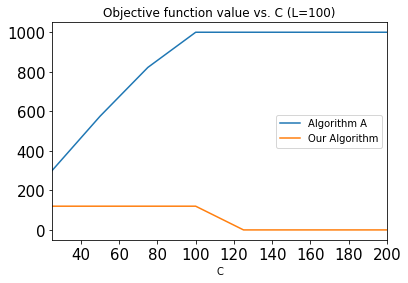

In [93]:
plots1.head(8).plot(x='C',y=['Algorithm A','Our Algorithm'],title='Objective function value vs. C (L=100)',fontsize=15)

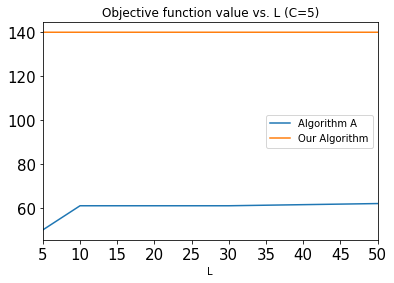

In [94]:
plots1.tail(5).plot(x='L',y=['Algorithm A','Our Algorithm'],title='Objective function value vs. L (C=5)',fontsize=15)

In [99]:
plots1.drop('Unnamed: 0', axis=1)[['C','L','Algorithm A','Our Algorithm','Items','Users']].to_csv('TableLatex.csv')